# 標準ライブラリのインポート

In [1]:

import re
import random
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from imblearn.over_sampling import SMOTE
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# データの読み込み

## 正規化データ

In [2]:
label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
# label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

# データフレームの読み込み
dataframe_path = r'.\input\dataframe\\'
# excelファイルの保存先のパス
output_path = r'.\output\\'
# 各フォルダの読み込み
folder_list = glob.glob(r'.\input\spectra_data\*')
# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# csvファイルからの読み込み

In [3]:
file_dic = {}
for n, folder in enumerate(folder_list):
    file_dic[f'data_{n+1}'] = glob.glob(folder + '\*')

df_list = []

for folder in file_dic:
    # フォルダ内にファイルがある場合
    if len(file_dic[folder]) > 0:
        # 各種データ保存用のディクショナリを作成
        data_dic = {}

        # テクストファイルの読み込み
        for file in file_dic[folder]:
            # ファイル名の切り取り
            file_name = re.split('[\\\\.]', file)[5]

            # 一時保存用リストの作成
            temp_list = []

            # スペクトルデータの読み込み
            with open(file, encoding='utf-8') as f:
                for row in f:
                    row = row.strip()
                    temp_list.append(re.split(sep, row))
            temp_list = temp_list[31:870]

            # ディクショナリへデータの格納
            data_dic[file_name] = temp_list

        # 空のデータフレームを作成
        df = pd.DataFrame()

        # フォルダ内データをデータフレームに追加
        for key in data_dic:
            intensity_list = []
            wave_list = []

            for n in range(len(data_dic[key])):
                intensity_list.append(data_dic[key][n][3])

            for n in range(len(data_dic[key])):
                wave_list.append(data_dic[key][n][0])

            df['Raman Shift'] = wave_list
            df[key] = intensity_list

        df = df.astype(float)
        df = df.sort_values(by=['Raman Shift'], ascending=True).reset_index(drop=True)

        df_list.append(df)

    else:
        break

# スペクトルの標準化＆データフレーム作成

In [4]:
standard_df_list = []

# スペクトルを波数方向に標準化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = StandardScaler()
    series = scaler.fit_transform(df[yaxis_list])
    standard_df = pd.DataFrame(series)
    standard_df.columns = yaxis_list
    standard_df.insert(0, 'Raman Shift', df['Raman Shift'])

    standard_df_list.append(standard_df)

RAMAN_SHIFT = df_list[0]['Raman Shift']
RAMAN_SHIFT["label"] = "label"

# 解析用に形状変更
for n, df in enumerate(standard_df_list):
    df.loc[-1] = int(n)

std_data_df = pd.concat(standard_df_list, axis=1)
std_data_df = std_data_df.drop(['Raman Shift'], axis=1)
std_data_df = std_data_df.T
std_data_df.columns = RAMAN_SHIFT

# pklファイルからの読み込み

In [9]:
# ファイル名
dataframe_title = 'CH3_COOH_scaled_df'

# pickelファイルの読み込み
norm_data_df = pd.read_pickle(dataframe_path + dataframe_title + '.pkl')
# データフレームの表示
norm_data_df.head()

Raman Shift,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,219.570432352812,...,1994.36035611163,1995.84667029798,1997.33255467823,1998.81800943131,2000.30303473604,2001.78763077115,2003.27179771526,2004.7555357469,2006.2388450445,label
CH3-COOH_1-0_01,0.009167,0.015687,0.009611,0.008422,0.002401,0.006682,0.009849,0.014186,0.013298,0.015276,...,0.022375,0.021647,0.020201,0.020255,0.023505,0.021797,0.023807,0.022947,0.021759,0.0
CH3-COOH_1-0_02,0.014455,0.011535,0.009954,0.011833,0.012432,0.007859,0.015521,0.021124,0.014055,0.027501,...,0.032174,0.032943,0.031873,0.033845,0.034684,0.034886,0.035371,0.033591,0.034924,0.0
CH3-COOH_1-0_03,0.003706,0.003276,0.002901,0.001596,0.001950,0.007356,0.007082,0.014574,0.010710,0.014859,...,0.025391,0.027310,0.027440,0.026706,0.027451,0.025421,0.025981,0.025985,0.026236,0.0
CH3-COOH_1-0_04,0.012741,0.004619,0.007832,0.004834,0.004279,0.010822,0.007751,0.010226,0.009832,0.013910,...,0.021855,0.023413,0.023656,0.022050,0.022651,0.022595,0.022241,0.024333,0.024754,0.0
CH3-COOH_1-0_05,0.020207,0.015031,0.016544,0.023040,0.012281,0.013707,0.022644,0.019758,0.020718,0.023377,...,0.036726,0.036650,0.036573,0.036054,0.036355,0.038046,0.034999,0.035362,0.035726,0.0


In [10]:
# 特徴量とラベルの分離
norm_data_label = norm_data_df['label']
norm_data_feature = norm_data_df.drop('label', axis=1)

# 各ラベルの平均スペクトル計算

In [5]:
std_avg_spectra_df = std_data_df.groupby("label").mean()
std_avg_spectra_df

Raman Shift,199.147424,201.192791,203.237476,205.281480,207.324801,209.367441,211.409400,213.450678,215.491276,217.531194,...,1688.209250,1689.785261,1691.360804,1692.935879,1694.510488,1696.084629,1697.658304,1699.231512,1700.804253,1702.376528
label,,,,,,,,,,,,,,,,,,,,,
0.0,-0.319297,-0.364494,-0.390672,-0.401126,-0.401864,-0.396517,-0.391197,-0.373773,-0.351517,-0.330747,...,-0.240290,-0.239099,-0.232143,-0.236293,-0.228718,-0.229274,-0.220300,-0.215889,-0.206692,-0.202399
1.0,-0.320699,-0.357344,-0.357379,-0.379641,-0.372982,-0.352879,-0.351169,-0.346582,-0.326114,-0.293908,...,-0.231501,-0.225501,-0.216139,-0.216462,-0.212568,-0.215501,-0.212587,-0.201661,-0.198531,-0.196544
2.0,-0.349761,-0.364231,-0.375025,-0.374224,-0.364880,-0.360441,-0.337917,-0.334787,-0.323866,-0.300725,...,-0.221665,-0.219665,-0.213666,-0.217368,-0.215158,-0.204531,-0.201462,-0.199798,-0.193373,-0.187550
3.0,-0.357952,-0.364175,-0.372916,-0.369714,-0.369312,-0.347814,-0.338304,-0.325363,-0.307308,-0.296233,...,-0.205159,-0.207949,-0.201101,-0.200393,-0.199008,-0.194206,-0.186349,-0.189771,-0.186228,-0.183855
4.0,-0.327091,-0.316662,-0.317961,-0.309244,-0.305316,-0.291535,-0.285251,-0.291314,-0.280824,-0.280883,...,-0.154520,-0.147799,-0.138956,-0.140206,-0.138590,-0.129800,-0.134296,-0.134238,-0.134480,-0.126175


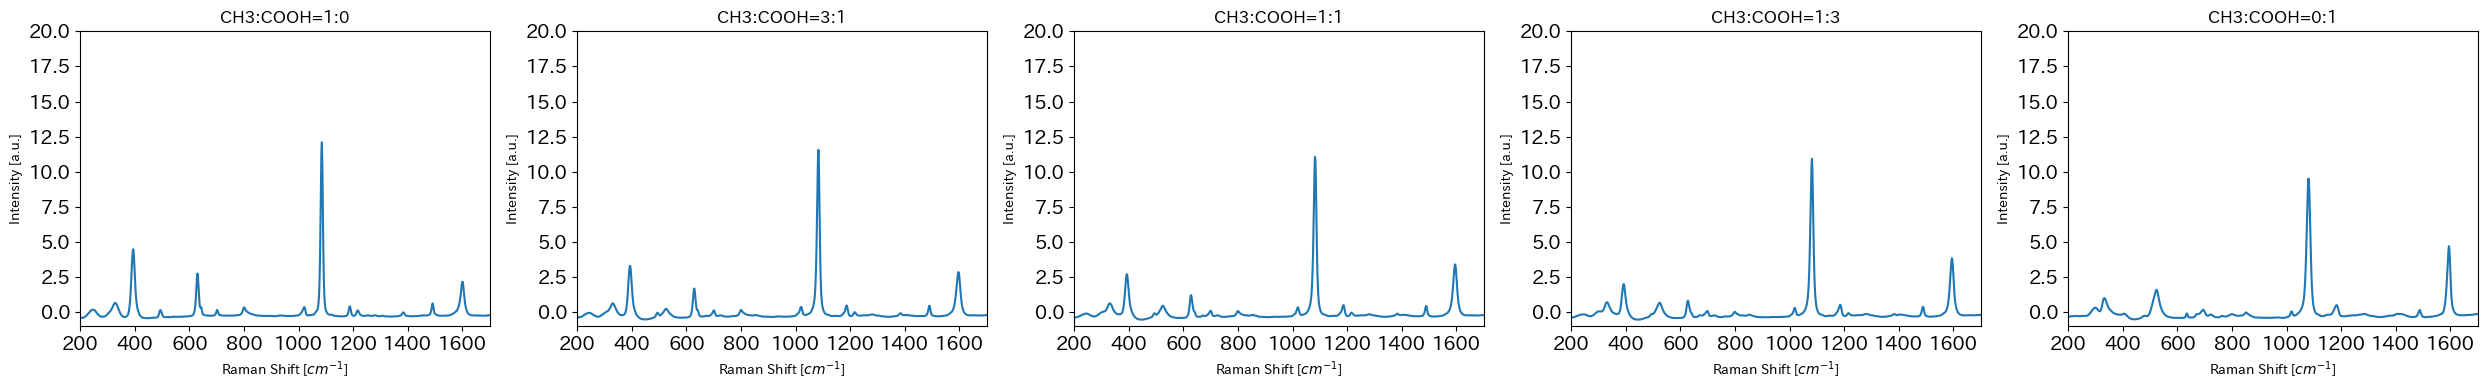

In [6]:
# X軸の最大・最小の設定
XLIM_MIN = 200
XLIM_MAX = 1700
# Y軸の最大・最小の設定
YLIM_MIN = -1
YLIM_MAX = 20
# 軸ラベルの設定
XLABEL = 'Raman Shift [$cm^{-1}$]'
YLABEL = 'Intensity [a.u.]'
# グラフサイズ
GRAPH_SIZE = (8, 6)
# フォントサイズ
FONTS_SIZE = 14

def show_raman_spectra(spectra_df):
    """
    ラマンスペクトルを表示する関数
    :param spectra_df_list: 各スペクトルデータフレームのリスト
    """
    plt.figure(figsize=(25, 4))
    for i in range(len(spectra_df)):
        plt.subplot(1, 5, i+1)
        plt.plot(spectra_df.columns , spectra_df.iloc[i])
        plt.title(label_list[i])
        plt.xlim(XLIM_MIN, XLIM_MAX)
        plt.ylim(YLIM_MIN, YLIM_MAX)

        plt.xlabel(XLABEL)
        plt.ylabel(YLABEL)
        plt.xticks(fontsize=FONTS_SIZE)
        plt.yticks(fontsize=FONTS_SIZE)

    plt.tight_layout()
    plt.show()

# グラフの表示
show_raman_spectra(std_avg_spectra_df)

# 学習データの生成

In [7]:
# oversampling用のパラメータ
NUMBER_NOISE = 160
NOISE_UPPER = 0.3
NOISE_UNDER = -0.3
NUMBER_SMOTE = 200

In [8]:
def aurgumentation_spectra(avg_spectra_df):
    # 学習用データフレームの作成
    train_df = pd.DataFrame()

    # ノイズを加えたデータの作成
    for i in range(NUMBER_NOISE):
        df = avg_spectra_df.copy()
        df = df.apply(lambda x: x + x * random.uniform(NOISE_UNDER, NOISE_UPPER))
        train_df = pd.concat([train_df, df], axis=0)

    # 学習用データの変数とラベルの分離
    train_df = train_df.sort_index().reset_index()
    train_X_df = train_df.drop(["label"], axis=1)
    train_y_df = train_df["label"]

    # SMOTE参照用データの作成（このデータフレームの数に合うようにoversampling）
    ref_data = np.ones((NUMBER_SMOTE, train_X_df.shape[1]))
    ref_df = pd.DataFrame(ref_data, columns=train_X_df.columns)
    ref_df.insert(0,'label', -1)
    # ノイズを加えたデータと参照用データを合わせたデータフレームの作成
    oversampling_df = pd.concat([train_df, ref_df], axis=0)

    # ラベルごとにoversamplingを実施
    for i in train_y_df.unique():
        X = oversampling_df[(oversampling_df["label"] == i) | (oversampling_df["label"] == -1)].drop("label", axis=1)
        y = oversampling_df[(oversampling_df["label"] == i) | (oversampling_df["label"] == -1)]["label"].values

        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X, y)

        temp_df = pd.DataFrame(X_res.iloc[len(X):], columns=train_X_df.columns)
        temp_df.insert(0, "label", y_res[len(y):])

        train_df = pd.concat([train_df, temp_df], axis=0)

        train_df = train_df.sort_index()

    return train_df

In [9]:
train_df = aurgumentation_spectra(std_avg_spectra_df)

# 学習用データの準備
train_X = train_df.drop("label", axis=1)
train_y = train_df["label"]

# 評価用データの準備
valid_X = std_data_df.drop("label", axis=1)
valid_y = std_data_df["label"]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

# SVM

In [10]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def svm_only(C, trn_X, trn_y, val_X, val_y):
    # SVM処理
    trn_X.columns = [str(i) for i in trn_X.columns]
    val_X.columns = [str(i) for i in val_X.columns]

    svm_model = SVC(C=C)
    svm_model.fit(trn_X, trn_y)
    y_pred = svm_model.predict(val_X)

    cm = confusion_matrix(y_pred, val_y)
    # 正解率
    Accuracy = accuracy_score(y_pred, val_y)

    return cm, Accuracy

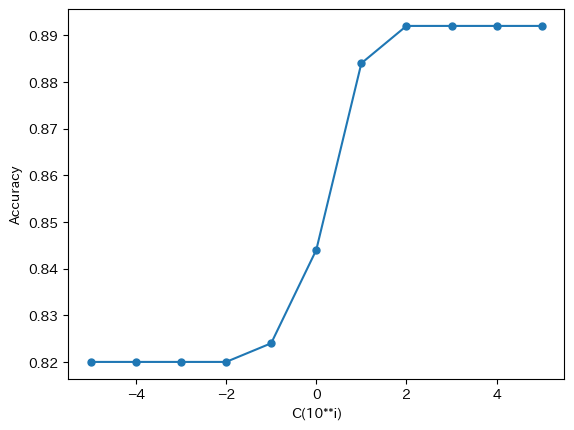

In [11]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, train_X, train_y, valid_X, valid_y)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [12]:
cm_svm, accuracy_svm = svm_only(100, train_X, train_y, valid_X, valid_y)
print('Accuracy:', accuracy_svm)

Accuracy: 0.892


<Axes: >

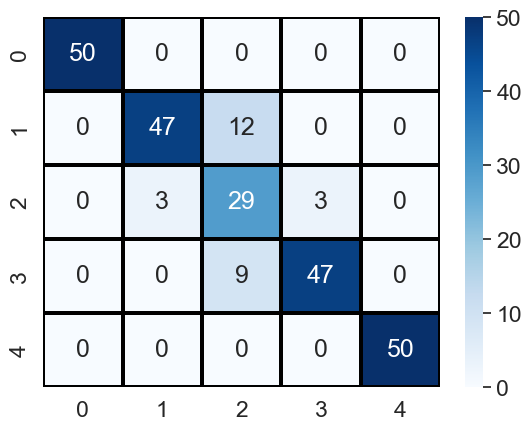

In [13]:
sns.set(font_scale=1.5)
sns.heatmap(cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# PCA-SVM

In [14]:
def pca_svm(n_comp, C, trn_X, trn_y, val_X, val_y):
    # PCA処理
    pca = PCA(n_components=n_comp)
    trn_X_pca = pca.fit_transform(trn_X.values)

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=trn_X.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # 評価用データのPCA処理
    val_X_pca = pca.transform(val_X.values)

    # SVM処理
    svm_model = SVC(C=C)
    svm_model.fit(trn_X_pca, trn_y)
    y_pred = svm_model.predict(val_X_pca)

    cm = confusion_matrix(y_pred, val_y)
    # 正解率
    Accuracy = accuracy_score(y_pred, val_y)

    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

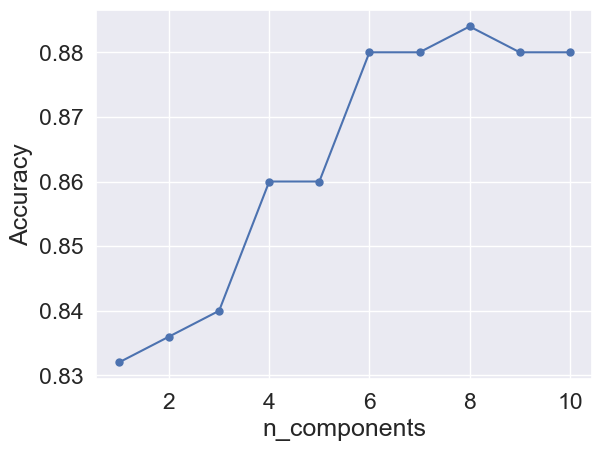

In [15]:
# n_componentsの決定
temp_accuracy_dict = {}

# 全波数での予測時：1-11
for n_comp in range(1, 11, 1):
    _, _, _, accuracy = pca_svm(n_comp, 1, train_X, train_y, valid_X, valid_y)
    temp_accuracy_dict[n_comp] = accuracy

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.show()

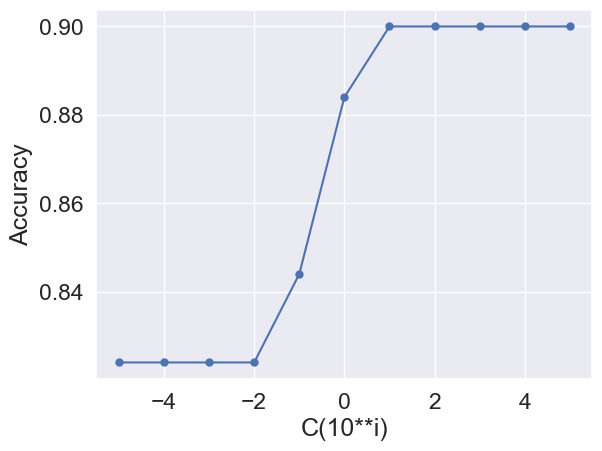

In [16]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, _, _, accuracy_pca_svm = pca_svm(8, 10**i, train_X, train_y, valid_X, valid_y)
    temp_accuracy_dict[i] = accuracy_pca_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [17]:
# n_components = 2
raitio, _, pca_svm_cm, pca_svm_accuracy = pca_svm(8, 10, train_X, train_y, valid_X, valid_y)
print(raitio)
print(pca_svm_accuracy)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.680014  0.066557  0.040435  0.034406  0.028235  0.023204  0.019197   

        PC8  
0  0.012068  
0.9


<Axes: >

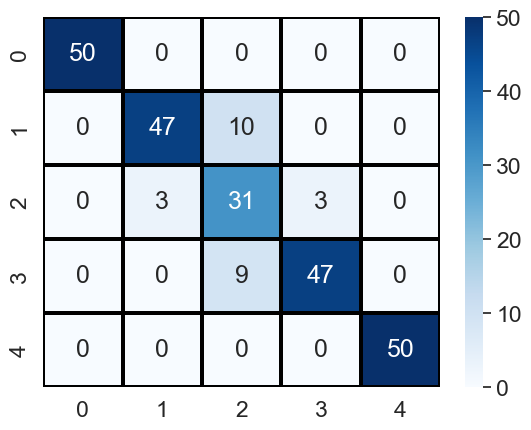

In [18]:
sns.set(font_scale=1.5)
sns.heatmap(pca_svm_cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# LDA

In [19]:
def lda_prediction(n_comp, trn_X, trn_y, val_X, val_y):

    lda_model = LDA(n_components=n_comp)
    lda_model.fit(trn_X, trn_y)
    y_pred = lda_model.predict(val_X)

    cm = confusion_matrix(y_pred, val_y)
    # 正解率
    Accuracy = accuracy_score(y_pred, val_y)

    return cm, Accuracy

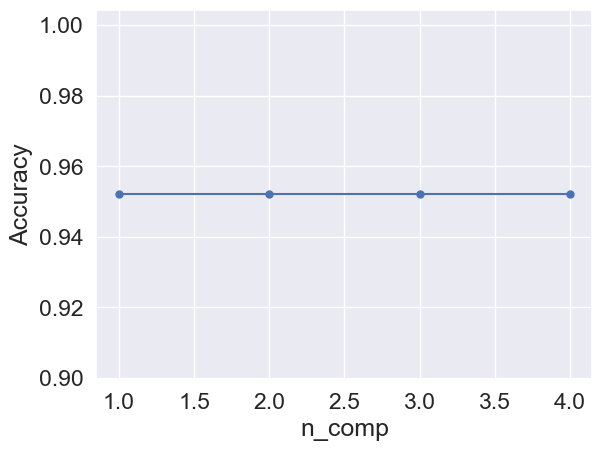

In [20]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 5, 1):
    _, accuracy_lda = lda_prediction(n_comp, train_X, train_y, valid_X, valid_y)
    temp_accuracy_dict[n_comp] = accuracy_lda

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

In [21]:
cm_lda, accuracy_lda = lda_prediction(2, train_X, train_y, valid_X, valid_y)
print('Accuracy:', accuracy_lda)

Accuracy: 0.952


<Axes: >

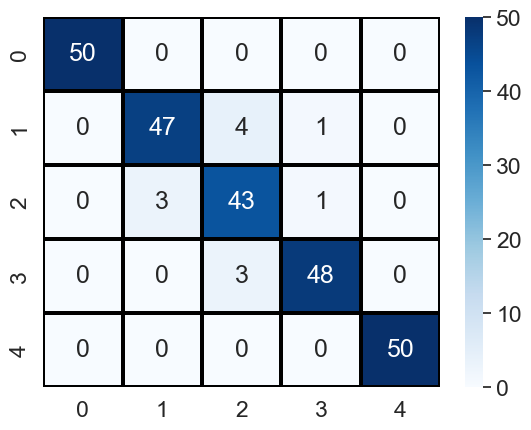

In [22]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Decision Tree

In [80]:
dt_model = DecisionTreeClassifier(random_state=1234)

# 施行するパラメータを設定
params = {
	'max_depth':[i for i in range(3, 11, 1)],
	'min_samples_split':[i for i in range(2, 11, 1)],
	'min_samples_leaf':[i for i in range(1, 11, 1)]
}

grid_search = GridSearchCV(dt_model, param_grid=params, cv=5)
grid_search.fit(train_X, train_y)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

1.0
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [81]:
def decision_tree(max_depth, min_leaf, min_split, trn_X, trn_y, val_X, val_y):

    trn_X.columns = [str(i) for i in trn_X.columns]

    dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                    min_samples_split=min_split,
                                    min_samples_leaf=min_leaf,
                                    max_leaf_nodes=None,
                                    random_state=1234)

    dt_model.fit(trn_X, trn_y)
    y_pred = dt_model.predict(val_X)

    cm = confusion_matrix(y_pred, val_y)
    # 正解率
    Accuracy = accuracy_score(y_pred, val_y)

    return cm, Accuracy

In [82]:
cm_dt, accuracy_dt = decision_tree(3, 1, 2, train_X, train_y, valid_X, valid_y)
print('Accuracy:', accuracy_dt)

Accuracy: 0.824


<Axes: >

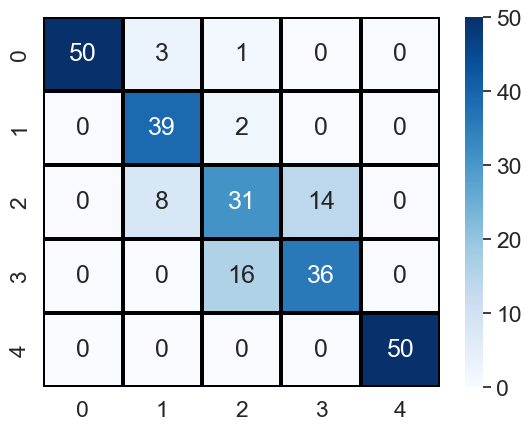

In [83]:
sns.set(font_scale=1.5)
sns.heatmap(cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# MLP

In [74]:
MLP_model = MLPClassifier(max_iter=10000, random_state=1234)

# 施行するパラメータを設定
params = {
	'hidden_layer_sizes':[(100), (200), (300), (50, 50), (50, 100), (100, 50), (100, 100), (200, 100), (200, 200)],
	'activation':['logistic', 'tanh', 'relu'],
	'solver':['sgd', 'adam']
}

grid_search = GridSearchCV(MLP_model, param_grid=params, cv=5)
grid_search.fit(train_X, train_y)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

1.0
{'activation': 'logistic', 'hidden_layer_sizes': 100, 'solver': 'sgd'}


In [75]:
def MLP(hidden_layer, activ, solv, trn_X, trn_y, val_X, val_y):

    trn_X.columns = [str(i) for i in trn_X.columns]

    MLP_model = MLPClassifier(hidden_layer_sizes=hidden_layer,
                            activation=activ, # logistic, tanh, relu
                            solver=solv,
                            max_iter=10000,
                            random_state=1234)

    MLP_model.fit(trn_X, trn_y)
    y_pred = MLP_model.predict(val_X)

    cm = confusion_matrix(y_pred, val_y)
    # 正解率
    Accuracy = accuracy_score(y_pred, val_y)

    return cm, Accuracy

In [79]:
cm_MLP, accuracy_MLP= MLP((100), 'logistic', 'adam', train_X, train_y, valid_X, valid_y)
print('Accuracy:', accuracy_MLP)

Accuracy: 0.924


<Axes: >

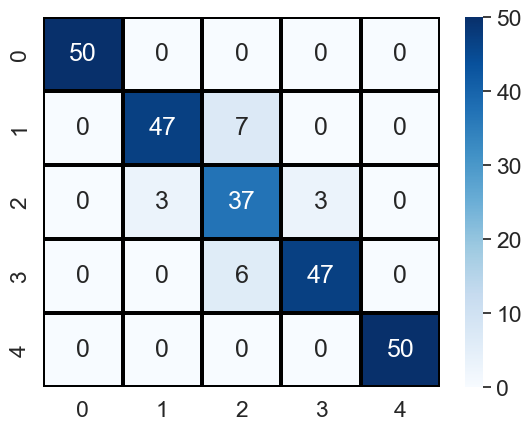

In [77]:
sns.set(font_scale=1.5)
sns.heatmap(cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# 特徴量選択

In [23]:
corr_ = abs(train_X.corr())
corr_list = []

for i in range(len(corr_)):
    temp_corr = corr_.iloc[i].sort_values()[-2]
    corr_list.append(temp_corr)

corr_df = pd.DataFrame(corr_list, index=corr_.index, columns=["corr"])
corr_df.head()

,corr
199.147423618928,0.273847
201.192791188876,0.339101
203.237476388369,0.416922
205.281479548654,0.477040
207.324801000766,0.505676


In [24]:
from sklearn.model_selection import train_test_split

trn_X, test_X, trn_y, test_y = train_test_split(valid_X, valid_y,
                                                    test_size=0.2,
                                                    random_state=1234)

SVM_model = SVC(C=100)

SVM_model.fit(trn_X, trn_y)

y_pred = SVM_model.predict(test_X)

# 正解率
Accuracy = accuracy_score(test_y, y_pred)
print('Accuracy:', Accuracy)

Accuracy: 1.0


In [14]:
explainer = shap.KernelExplainer(SVM_model.predict, test_X)
shap_values = explainer.shap_values(test_X)

shap_df = pd.DataFrame(shap_values,
                       columns=test_X.columns,
                       index=test_X.index)

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
# 各モデルの定義
svc_model = SVC(C=100)

class pca_svc_model():
    def __init__(self):
        self.pca = PCA(n_components=3).fit(train_X.values)
        self.svc_model = SVC(C=1)

    def fit(self, X, y):
        pca_train = self.pca.transform(X)
        self.svc_model.fit(pca_train, y)

    def predict(self, X):
        pca_test = self.pca.transform(X)
        model_prediction = self.svc_model.predict(pca_test)

        return model_prediction

lda_model = LDA(n_components=3)

dt_model = DecisionTreeClassifier(max_depth=5,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_leaf_nodes=None,
                                random_state=1234)

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                                activation='logistic', # logistic, tanh, relu
                                solver='adam',
                                max_iter=1000,
                                random_state=1234)

In [26]:
def shap_calculation(trn_X, trn_y, val_X, val_y, model):
    """
    shap_valueを計算する関数
    :param trn_X: 学習用説明変数（データフレーム型）
    :param trn_y: 学習用目的変数
    :param val_X: 評価用説明変数（データフレーム型）
    :param val_y: 評価用目的変数
    :papam model: 使用する予測モデル
    :return: shap値、SHAPの期待値、SHAPの期待値の平均値、予測結果
    """
    #trn_X.columns = [str(i) for i in trn_X.columns]
    #val_X.columns = [str(i) for i in val_X.columns]
    # モデルのインスタンス化&学習
    pred_model = model
    pred_model.fit(trn_X, trn_y)
    # モデルの予測
    y_pred = pred_model.predict(val_X)
    # 正解率の計算
    Accuracy = accuracy_score(val_y, y_pred)
    print('Model Accuracy:', Accuracy)

    # shapの計算
    explainer = shap.KernelExplainer(pred_model.predict, val_X.values)
    shap_values = explainer.shap_values(val_X.values)
    # shap値をデータフレームに変換
    shap_df = pd.DataFrame(shap_values)
    # shapの絶対値の平均値を計算
    abs_mean_shap_df = shap_df.apply(np.abs).mean()
    abs_mean_shap_df.index = abs_mean_shap_df.index.astype(float)
    # shap値全体の平均値
    shap_expected_value = explainer.expected_value

    return shap_df, abs_mean_shap_df, shap_expected_value


In [27]:
shap_df, abs_mean_shap_df, shap_expected_value = shap_calculation(train_X, train_y, valid_X, valid_y, svc_model)

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Model Accuracy: 0.892


  0%|          | 0/250 [00:00<?, ?it/s]

<Axes: >

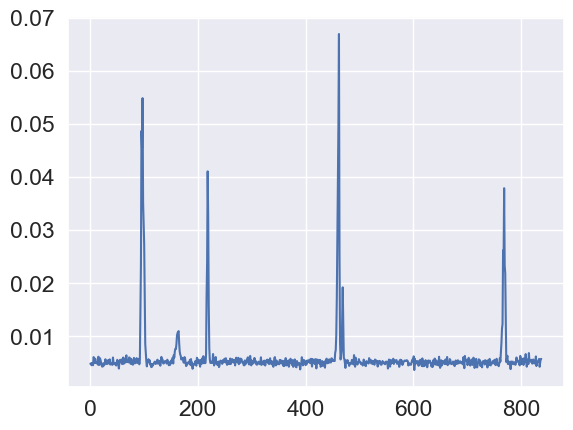

In [28]:
abs_mean_shap_df.plot()

In [31]:
corr_shap_df = corr_df.copy()
corr_shap_df["SHAP"] = abs_mean_shap_df.values
corr_shap_df.head()

,corr,SHAP
199.147423618928,0.273847,0.004838
201.192791188876,0.339101,0.004911
203.237476388369,0.416922,0.004561
205.281479548654,0.477040,0.004962
207.324801000766,0.505676,0.004953


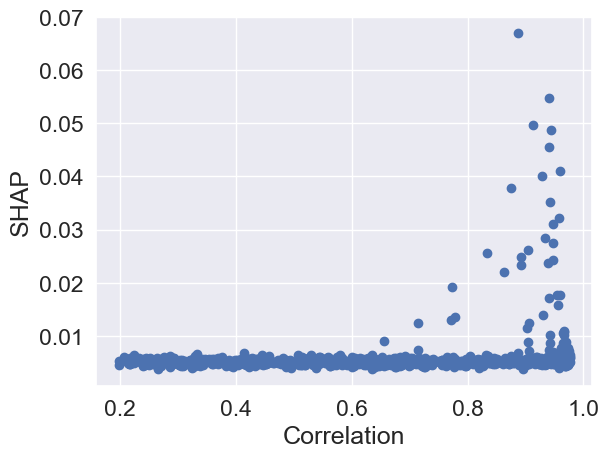

In [32]:
plt.scatter(corr_shap_df["corr"], corr_shap_df["SHAP"])
plt.xlabel("Correlation")
plt.ylabel("SHAP")
plt.show()

In [39]:
shap_select = corr_shap_df["SHAP"] > 0.01
train_X_shap_selected = train_X.loc[:, shap_select]
valid_X_shap_selected = valid_X.loc[:, shap_select]

print("train_X_shap_selected.shape = ", train_X_shap_selected.shape)
print("valid_X_shap_selected.shape = ", valid_X_shap_selected.shape)

train_X_shap_selected.shape =  (1000, 36)
valid_X_shap_selected.shape =  (250, 36)


In [40]:
cm_svm, accuracy_svm = svm_only(100, train_X, train_y, valid_X, valid_y)
print('Accuracy:', accuracy_svm)

cm_svm_selected, accuracy_svm_selected = svm_only(100, train_X_shap_selected, train_y, valid_X_shap_selected, valid_y)
print("Accuracy_selected:", accuracy_svm_selected)

Accuracy: 0.892
Accuracy_selected: 0.876


# PFI

In [41]:
SVM_model = SVC(C=100)

SVM_model.fit(train_X, train_y)
y_pred = SVM_model.predict(valid_X)

pfi_result = permutation_importance(SVM_model, valid_X, valid_y, n_repeats=50, n_jobs=-1, random_state=0)
pfi_mean_result = pfi_result.importances_mean
# pfi_std_result = pfi_result.importances_std

# 正解率
Accuracy = accuracy_score(valid_y, y_pred)
print('Accuracy:', Accuracy)

Accuracy: 0.892


<Axes: >

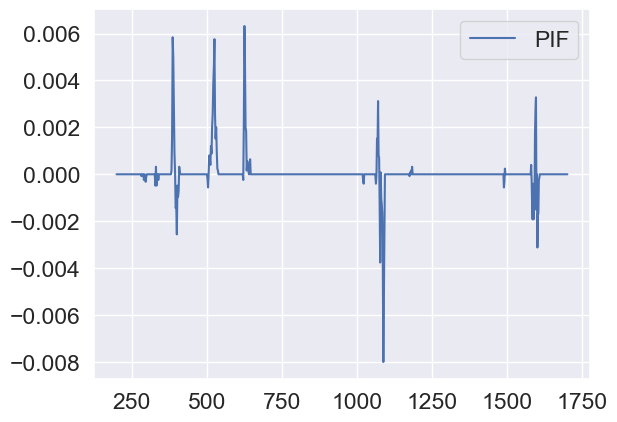

In [43]:
df = pd.DataFrame(pfi_mean_result, columns=['PIF'], index=train_X.columns)
df.index = df.index.astype(float)
df.plot()

In [44]:
corr_pfi_df = corr_df.copy()
corr_pfi_df["PFI"] = abs(pfi_mean_result)

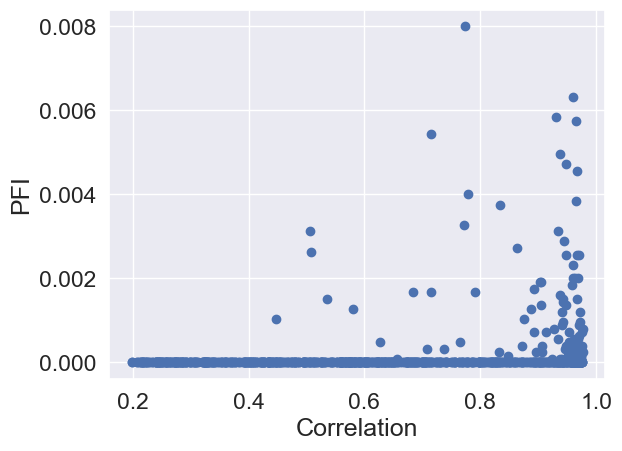

In [45]:
plt.scatter(corr_pfi_df["corr"], corr_pfi_df["PFI"])
plt.xlabel("Correlation")
plt.ylabel("PFI")
plt.show()

In [46]:
pfi_select = corr_pfi_df["PFI"] > 0.001
train_X_pfi_selected = train_X.loc[:, pfi_select]
valid_X_pfi_selected = valid_X.loc[:, pfi_select]

print("train_X_pfi_selected.shape = ", train_X_pfi_selected.shape)
print("valid_X_pfi_selected.shape = ", valid_X_pfi_selected.shape)

train_X_pfi_selected.shape =  (1000, 44)
valid_X_pfi_selected.shape =  (250, 44)


In [47]:
cm_svm, accuracy_svm = svm_only(100, train_X, train_y, valid_X, valid_y)
print('Accuracy:', accuracy_svm)

cm_svm_pfi_selected, accuracy_svm_pfi_selected = svm_only(100, train_X_pfi_selected, train_y, valid_X_pfi_selected, valid_y)
print("Accuracy_pfi_selected:", accuracy_svm_pfi_selected)

Accuracy: 0.892
Accuracy_pfi_selected: 0.892


In [ ]:
#
graph_title = 'shap_CH3_COOH'
# excelファイルの保存先のパス
abs_mean_shap_df.to_excel(output_path + graph_title + '.xlsx')